# Spotify: Valence prediction

* Load a diagnostic captioning dataset and discard the images.
* Explore the captions and the tags.
---

> Anastasios Moraitis, P2822110 <br/>
> Department of Management Science and Technology <br/>
> Athens University of Economics and Business <br/>
> p2822110@aueb.gr <br/>

## 0. Import Libraries, Helper Functions, and Data

### A. Libraries

In [63]:
#conda install -c conda-forge spotipy
import spotipy
import spotipy.util as util
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### B. Helper Functions

In [64]:
#### Get Audio Features for a list of songs in a text file.

def get_audio_features_for(provider: spotipy.client.Spotify, songs_csv_path):
    tracks_audio_ft = None
    chunk_size = 70
    for chunk in pd.read_csv(songs_csv_path, chunksize=chunk_size):
        audio_ft = provider.audio_features(np.str0.join(',', chunk['id']))

        try:
            cols = list(dict.keys(audio_ft[0]))
            tracks_audio_ft_temp = pd.DataFrame(audio_ft, columns=cols)

            if tracks_audio_ft is None:
                tracks_audio_ft = tracks_audio_ft_temp
            else:
                tracks_audio_ft = pd.concat([tracks_audio_ft, tracks_audio_ft_temp])
        except BaseException as e:
            # logs
            print('could not setup chunk')
            print(e)

    tracks_audio_ft.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)
    tracks_audio_ft.set_index('id', drop=True, inplace=True)

    return tracks_audio_ft

 More helper functions related to the song IDs:
- Get Playlist Items: gets the songs in playlist(id, userid)
- Get Search Items: gets the songs for the search criteria(by genre)
- Get Songs: from the given playlist (internally calls get_playlist_items)
- Clean Songs: Cleans duplicates and NAs from a list of songs

In [65]:
SONG_COL_NAMES = ['id', 'name']

def get_playlist_items(provider: spotipy.client.Spotify, playlist):
    r = provider.user_playlist_tracks(playlist[0], playlist[1])
    t = r['items']
    ids = []
    while r['next']:
        r = provider.next(r)
        t.extend(r['items'])
    try:
        for s in t: ids.append((str(s["track"]["id"]), str(s["track"]["name"])))
    except Exception as e:
        print('Couldnt append')
        print(e)
    return pd.DataFrame(ids, columns=SONG_COL_NAMES)

def get_search_items(provider: spotipy.client.Spotify, genre: str, times = 20):
    res = provider.search(q='genre:' + genre, type="track", limit=50)
    x = res.get("tracks")
    t = x['items']
    ids = []
    while x['next'] and str.find(x['next'], 'offset=1000') < 0 and times > 0:
        res = provider.next(x)
        x = res.get('tracks')
        t.extend(x['items'])
        times = times - 1
    try:
        for s in t: ids.append((str(s["id"]), str(s["name"])))
    except Exception as e:
        print('Couldnt append')
        print(e)
    return pd.DataFrame(ids, columns=SONG_COL_NAMES)

def get_songs(provider: spotipy.Spotify, playlists):
    songs = pd.DataFrame(columns=SONG_COL_NAMES)

    for playlist in playlists:
        result = get_playlist_items(provider, playlist)
        songs = pd.concat([songs, result])
    return songs

def clean_songs_map(songs):
    print('Initially got songs: ' + str(len(songs)))
    print('Unique songs by id: ' + str(len(songs['id'].unique())))
    # remove duplicates
    print('Dropping dubs by id...')
    songs.drop_duplicates(subset='id', inplace=True)
    print('Songs: ' + str(len(songs)))
    print('Unique songs by name: ' + str(len(songs['name'].unique())))
    print('Dropping dubs by name...')
    songs.drop_duplicates(subset='name', inplace=True)
    print('Songs: ' + str(len(songs)))
    print('Dropping NAs...')
    songs.dropna()
    print('Songs: ' + str(len(songs)))
    return songs

### Data

Set up the spotify API Client using Spotipy

In [66]:
CLIENT_ID = "6da00ef0fd0043ce9fcda74feca3e747"
CLIENT_SECRET = "3a74022d277d48e8a7d1d85d56dd68ef"

auth_manager=spotipy.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

Define a list of playlist found over the internet and download the songs.

In [67]:
playlists = [
   ('1130225252', '4rnleEAOdmFAbRcNCgZMpY'),
    ('twgeb7mzdcv4u8h191dxrvlpc', '5S8SJdl1BDc0ugpkEvFsIL'),
    ('raijin-_-', '3ZWRMtzrap0EosVqsU6IW3'),
    ('thedoctorkto', '54nv8jbrm4JoHEZ49Qvjgl'),
    ('bate_shashi', '1AzhiEXJx5hTuILrXM9WGO'),
    ('1178551233','4NjZYfQHwCuyVlv0eEFwoi'),
    ('ryanthenobody8750', '7I6XVNQVayB46Zzh4GNPoU'),
    ('t2xwvwe20b1z893l0g58dahvw', '0z085jfTrSXxhFUyKKExxJ'),
    ('31lvjp5jk72zzkjbz3rzyhjcu46i','3WWv2APRYe9jR8L1YnK1Up'),
    ('12160726861', '6yPiKpy7evrwvZodByKvM9'),
    ('exiedous','6FKDzNYZ8IW1pvYVF4zUN2'),
    ('v576q2ec1k3c5l2hwjp7i4rcq', '1oB39QsjKnobiesaOWwkRt')]

songs = clean_songs_map(get_songs(sp, playlists))

Couldnt append
'NoneType' object is not subscriptable
Couldnt append
'NoneType' object is not subscriptable
Initially got songs: 83611
Unique songs by id: 65824
Dropping dubs by id...
Songs: 65824
Unique songs by name: 53041
Dropping dubs by name...
Songs: 53041
Dropping NAs...
Songs: 53041


Save off the songs for future use

In [68]:
SONGS_CSV = './songs.csv'

In [69]:
songs.to_csv(SONGS_CSV, index=False)

Download the features of the songs from: https://api.spotify.com/v1/audio-features

In [70]:
dataset = get_audio_features_for(sp, SONGS_CSV)

dataset.isna().sum()

dataset.info()

could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
<class 'pandas.core.frame.DataFrame'>
Index: 52691 entries, 7dS5EaCoMnN7DzlpT6aRn2 to 6XQhcuKiotvDsk8rBlrySQ
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      52691 non-null  float64
 1   energy            52691 non-null  float64
 2   key               52691 non-null  int64  
 3   loudness          52691 non-null  float64
 4   mode              52691 non-null  int64  
 5   speechiness       52691 non-null  float64
 6   acousticness      52691 non-null  float64
 7   instrumentalness  52691 non-null  float64
 8   liveness          52691 non-null  float64
 9   valence           52691 non-null  float64
 10  tempo    

Save the dataset, too.

In [71]:
dataset.to_csv('./audio_features.csv')

### C. Analyze Valence

Valence distribution

It seems that valence is right skewed.

We are going to download more songs using the /search/ API endpoint.

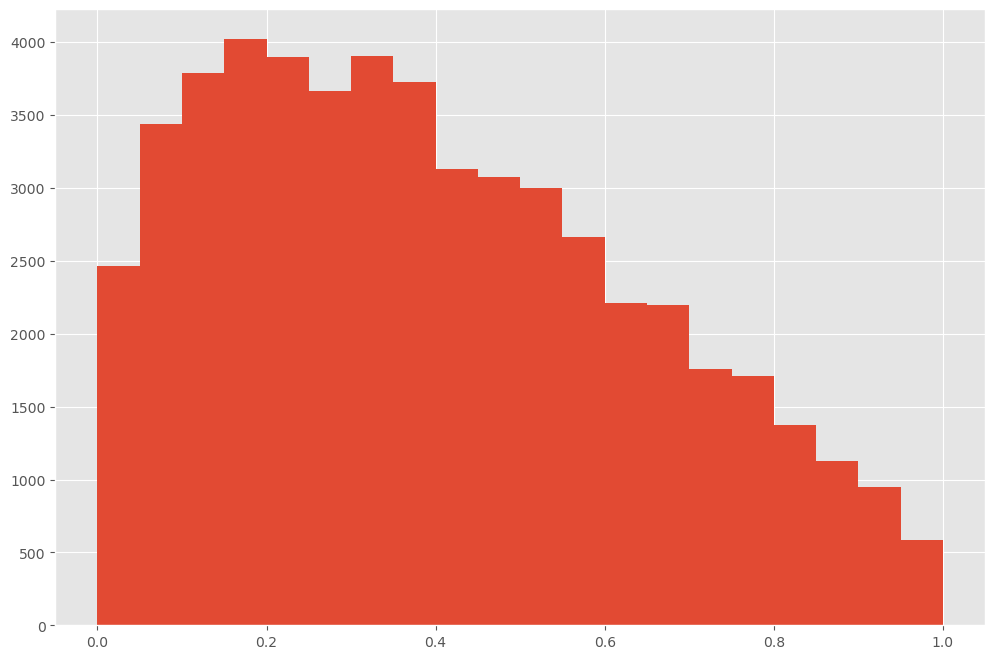

In [72]:
import matplotlib
import matplotlib.pyplot as plt

dataset['valence'].hist(bins=20, figsize=(12, 8))

plt.hist(dataset['valence'], 20, density = True, 
         histtype ='bar')
plt.show()

Download the TOP 500 genres by popularity.

In [73]:
# Additional data
url = 'https://everynoise.com/everynoise1d.cgi?scope=all'
music_types = pd.read_html(url)[0]
music_types.drop(1, axis=1, inplace=True)
music_types = music_types.head(500)

For each genre execute a search query and get the songs, extending the existing list of songs.

In [74]:
x = range(len(music_types))
for n in x:
    genre = music_types[2].iloc[n]
    songs = pd.concat([songs, get_search_items(sp, genre)])
songs = clean_songs_map(songs)

Initially got songs: 390601
Unique songs by id: 316946
Dropping dubs by id...
Songs: 316946
Unique songs by name: 220411
Dropping dubs by name...
Songs: 220411
Dropping NAs...
Songs: 220411


Save off songs

In [75]:
songs.to_csv(SONGS_CSV, index=False)

Download extra features for our new list

In [76]:
songs = pd.read_csv(SONGS_CSV)
new_dataset = get_audio_features_for(sp, SONGS_CSV)
dataset = pd.concat([dataset, new_dataset])
dataset.isna().sum()

dataset.info()

could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
could not setup chunk
'NoneType' object is not iterable
<class 'pandas.core.frame.DataFrame'>
Index: 272752 entries, 7dS5EaCoMnN7DzlpT6aRn2 to 1rJgKcK3ilp4xg7WxTs4RG
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      272752 non-null  float64
 1   energy            272752 non-null  float64
 2   key               272752 non-null  int64  
 3   loudness          272752 non-null  float64
 4   mode              272752 non-null  int64  
 5   speechiness       272752 non-null  float64
 6   acousticness      272752 non-null  float64
 7   instrumentalness  272752 non-null  float64
 8   liveness          272752 non-null  float64
 9   valence           272752 non-null  float64
 

In [77]:
dataset.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
7dS5EaCoMnN7DzlpT6aRn2,0.566,0.664,4,-5.303,0,0.0464,0.6340,0.000000,0.116,0.437,128.945,241688,4
2V4bv1fNWfTcyRJKmej6Sj,0.768,0.820,7,-4.630,0,0.0474,0.1790,0.000000,0.689,0.625,129.965,213293,4
7KA4W4McWYRpgf0fWsJZWB,0.558,0.559,6,-9.222,1,0.0959,0.3710,0.000007,0.109,0.620,78.558,180387,4
3gbBpTdY8lnQwqxNCcf795,0.679,0.715,9,-6.383,1,0.0407,0.0755,0.000000,0.271,0.571,127.435,214148,4
3ZFTkvIE7kyPt6Nu3PEa7V,0.778,0.824,10,-5.892,0,0.0707,0.2840,0.000000,0.405,0.758,100.024,218093,4


Now the distribution looks normal.

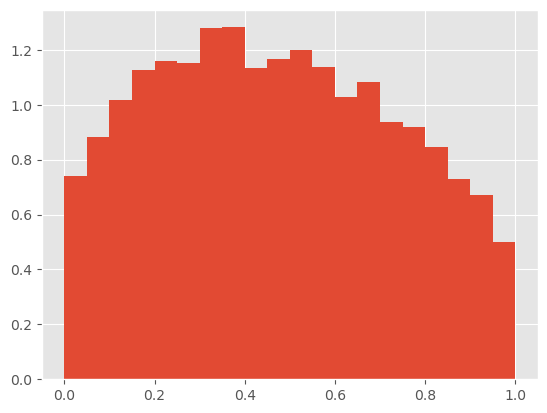

In [78]:
plt.hist(dataset['valence'], 20, density = True, 
         histtype ='bar')
plt.show()

Down-sample at 50% of the original, approximately 110k rows, and plot our target's variable distribution.

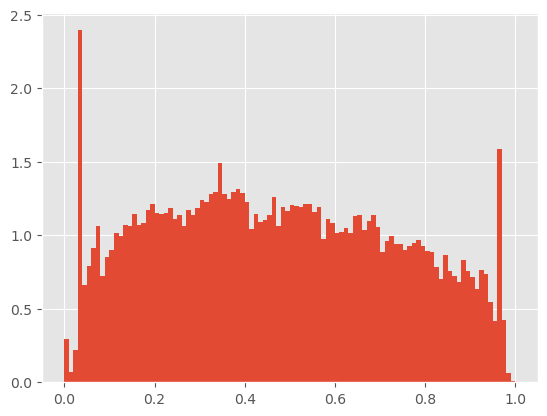

In [79]:
train_set = dataset.sample(frac=.5)

plt.hist(train_set['valence'], 100, density = True, 
         histtype ='bar')
plt.show()

Plot for-each variable

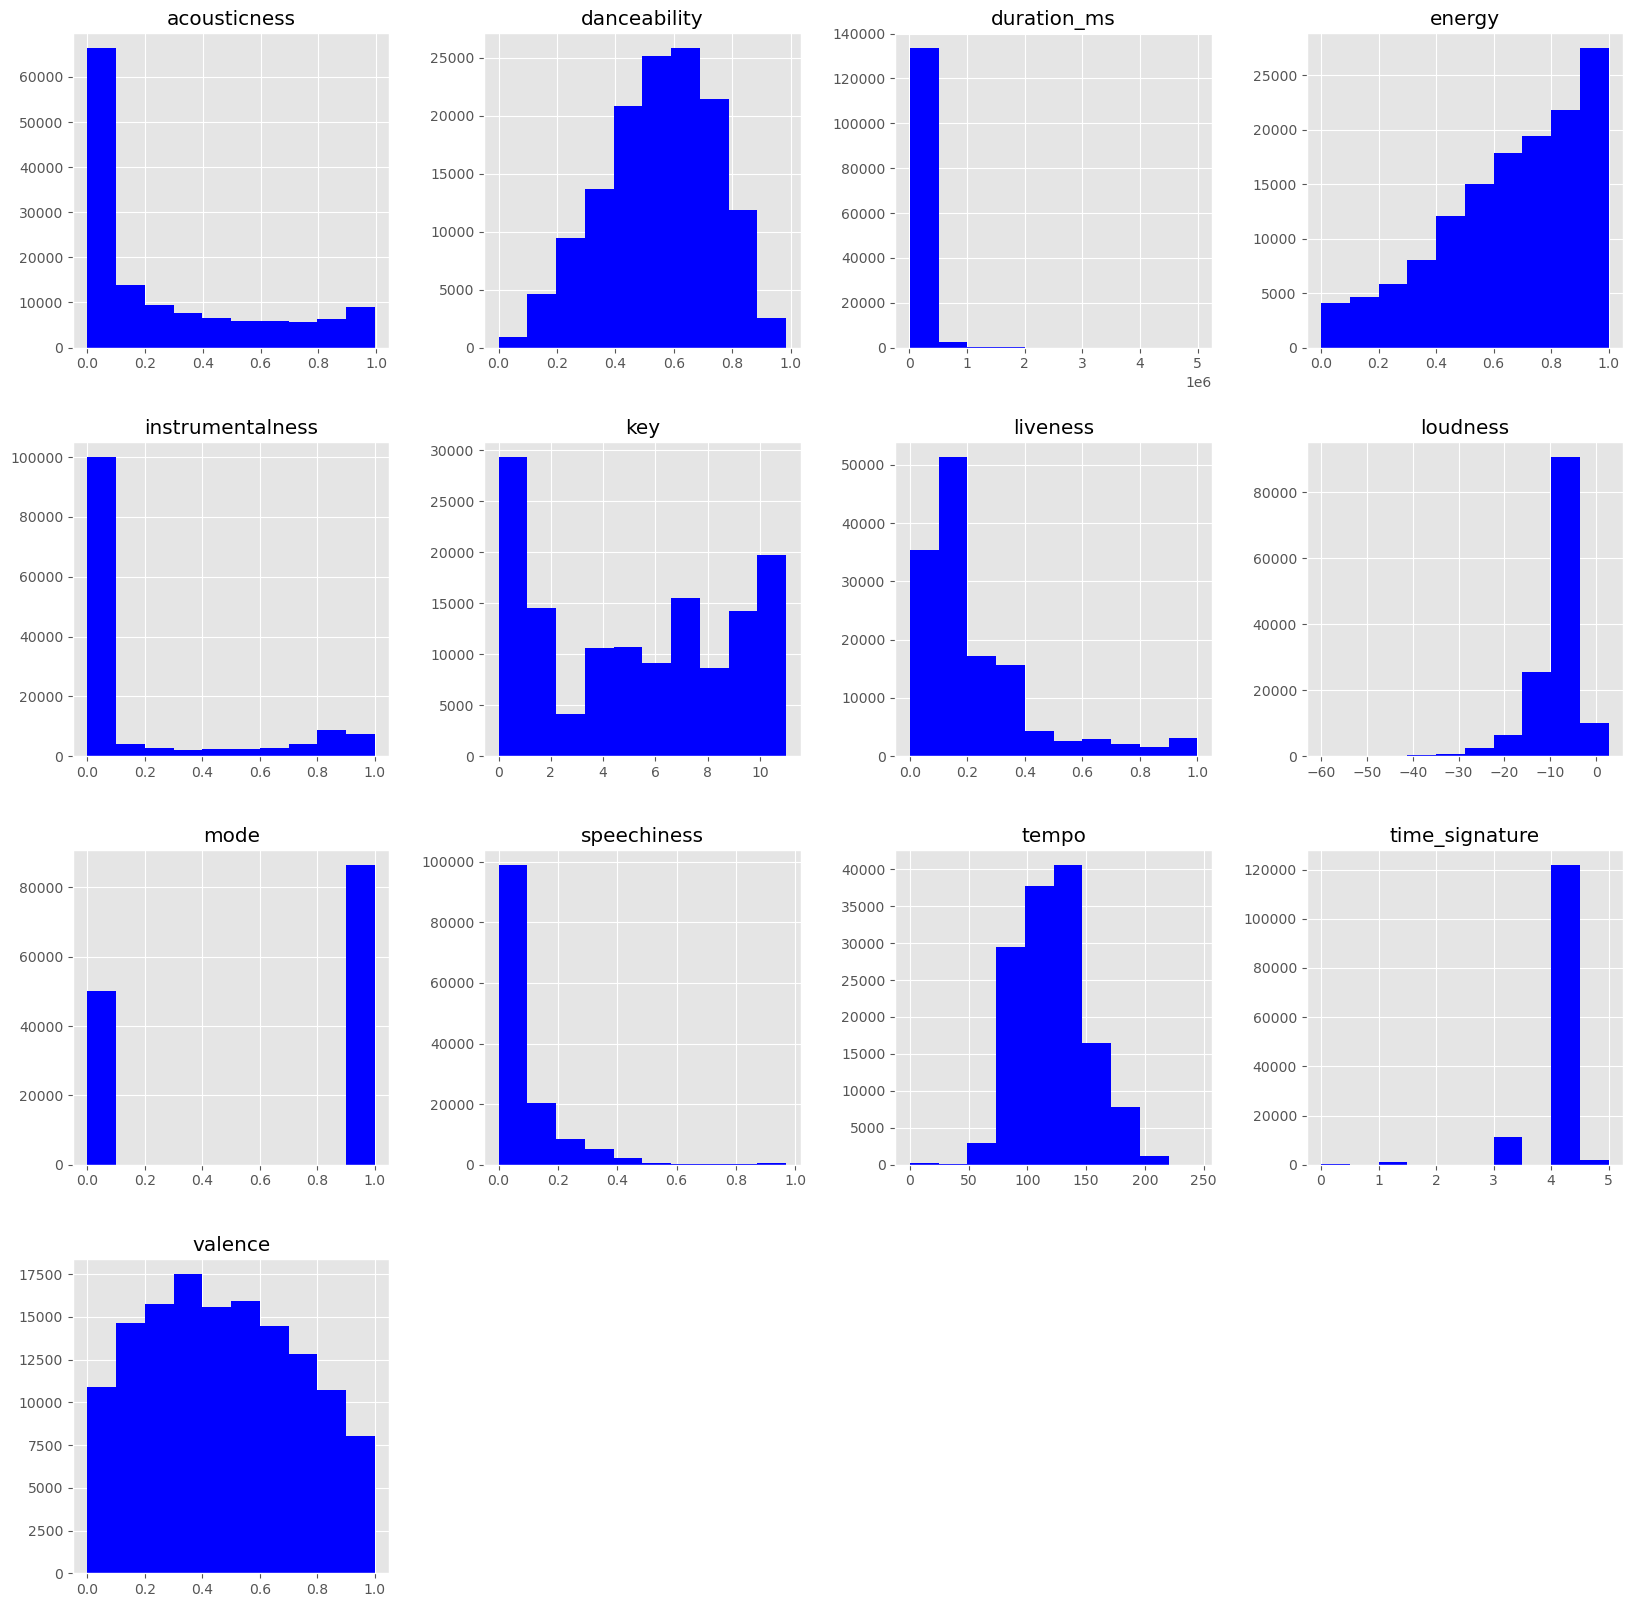

In [80]:
train_set.hist(figsize=(20, 20), color="b")
plt.show()
plt.style.use('ggplot')

acousticness

number<float>

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

\>= 0<= 1

analysis\_url

string

A URL to access the full audio analysis of this track. An access token is required to access this data.

danceability

number<float>

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

duration\_ms

integer

The duration of the track in milliseconds.

energy

number<float>

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

id

string

The Spotify ID for the track.

instrumentalness

number<float>

Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

key

integer

The key the track is in. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

\>= -1<= 11

liveness

number<float>

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness

number<float>

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

mode

integer

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

speechiness

number<float>

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

tempo

number<float>

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

time\_signature

integer

An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

\>= 3<= 7

track\_href

string

A link to the Web API endpoint providing full details of the track.

type

string

The object type.

Allowed value:"audio\_features"

uri

string

The Spotify URI for the track.

valence

number<float>

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

\>= 0<= 1

Investigate correlation patterns

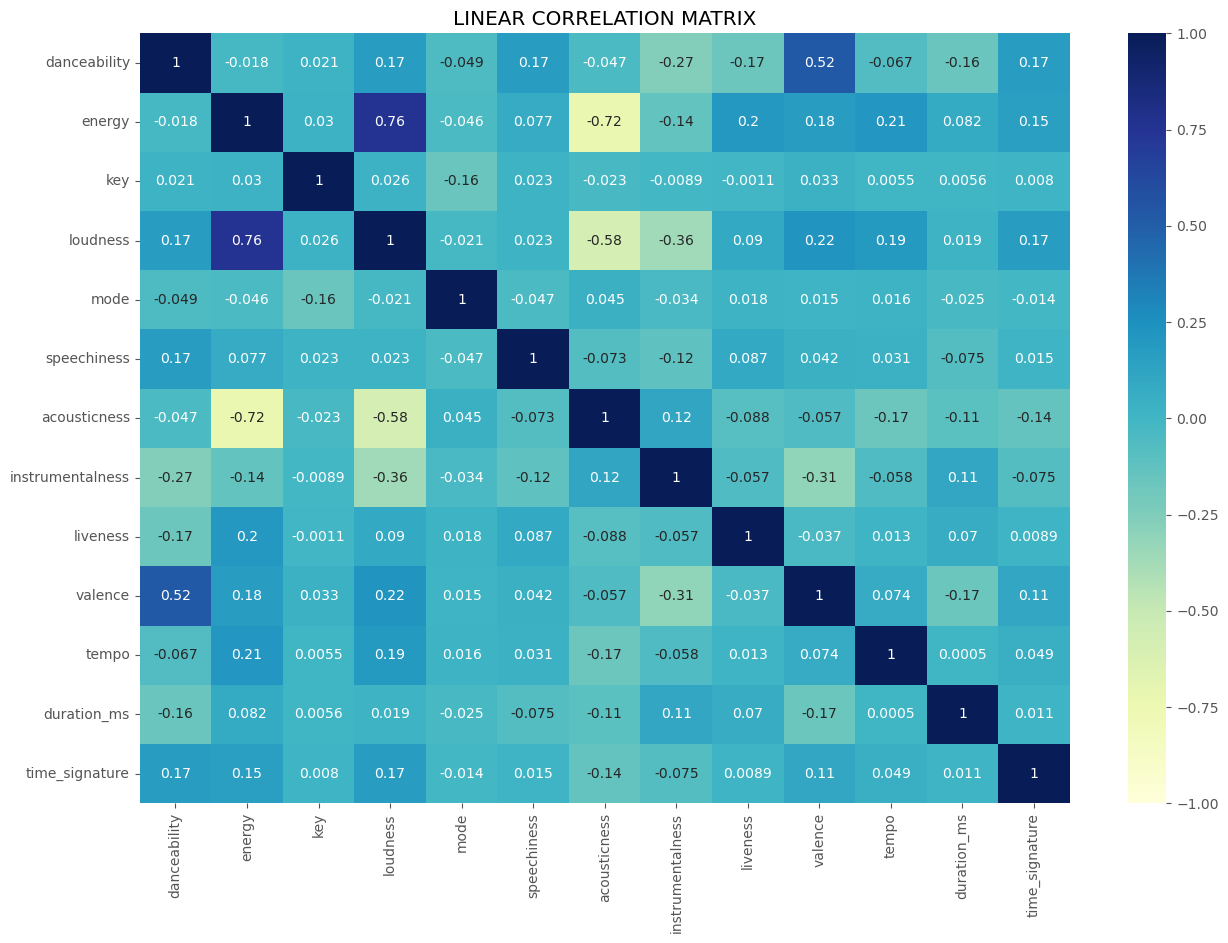

In [81]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train_set.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX')
plt.show()
plt.style.use('ggplot')

We notice a significant correlation between the sets (valence, danceability), and (loudness, energy)

Transform dataset show that the factor variables will be representing a sparse matrix.

In [129]:
# train_set.iloc[:, :-13].describe()

In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [82]:
def get_dataset_for_analysis(pandas_set):
    result = pd.get_dummies(pandas_set, columns=['key', 'mode', 'time_signature'], drop_first=True)
    #result[['loudness', 'tempo']] = scaler.fit_transform(result[['loudness', 'tempo']])
    return result

In [83]:
train_set = get_dataset_for_analysis(train_set)

Looking at the rest variables, two of them need scaling and duration will be at first transformed to seconds.

In [84]:
train_set.head(2)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
id,,,,,,,,,,,,,,,,,,,,,
51LIqkda3pTeECZUhMnool,0.838,0.546,-6.811,0.2950,0.153,0.000000,0.0656,0.745,137.027,206533,...,0,0,0,0,0,0,0,0,1,0
2JgUnjMIhY4JrWdE9ABlVJ,0.613,0.525,-7.545,0.0583,0.782,0.000025,0.0662,0.437,89.977,196000,...,0,0,0,0,0,0,0,0,1,0


Fit a Linear Regression model to see how the independent variables are affecting `valence`.

In [85]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
X_train = train_set[train_set.columns[~train_set.columns.isin(['valence'])]]
df_mod = smf.ols(formula='valence ~ ' + " + ".join(X_train), data=train_set)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3356.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:31:49   Log-Likelihood:                 21757.
No. Observations:              136376   AIC:                        -4.346e+04
Df Residuals:                  136350   BIC:                        -4.321e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2595      0.017    -15.384      0.000      -0.293      -0.226
danceability         0.7338      0.003    217.078      0.000       0.727       0.740
energy               0.4327      0.004    100.739      0.000       0.424       0.441
loudness            -0.0072      0.000    -37.390      0.000      -0.008      -0.007
speechiness         -0.1930      0.005    -36.930      0.000      -0.203      -0.183
acousticness         0.1632      0.003     62.905      0.000       0.158       0.168
instrumentalness    -0.1468      0.002    -73.421      0.000      -0.151      -0.143
liveness             0.0006      0.003      0.219      0.826      -0.005       0.006
tempo                0.0007   1.97e-05     35.523      0.000       0.001       0.001
duration_ms      -1.719e-07    4.7e-09    -36.572      0.000   -1.81e-07   -1.63e-07
key_1               -0.0453      0.002    -18.617      0.000      -0.050      -0.041
key_2               -0.0114      0.002     -4.783      0.000      -0.016      -0.007
key_3               -0.0061      0.004     -1.674      0.094      -0.013       0.001
key_4               -0.0101      0.003     -3.823      0.000      -0.015      -0.005
key_5                0.0072      0.003      2.777      0.005       0.002       0.012
key_6               -0.0105      0.003     -3.804      0.000      -0.016      -0.005
key_7               -0.0013      0.002     -0.572      0.567      -0.006       0.003
key_8               -0.0178      0.003     -6.396      0.000      -0.023      -0.012
key_9                0.0101      0.002      4.188      0.000       0.005       0.015
key_10               0.0015      0.003      0.522      0.602      -0.004       0.007
key_11              -0.0065      0.003     -2.470      0.014      -0.012      -0.001
mode_1               0.0201      0.001     16.577      0.000       0.018       0.022
time_signature_1    -0.0564      0.017     -3.266      0.001      -0.090      -0.023
time_signature_3    -0.0637      0.016     -3.891      0.000      -0.096      -0.032
time_signature_4    -0.0679      0.016     -4.168      0.000      -0.100      -0.036
time_signature_5    -0.0690      0.017     -4.099      0.000      -0.102      -0.036
==============================================================================
Omnibus:                     1234.578   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              853.473
Skew:                           0.070   Prob(JB):                    4.68e-186
Kurtosis:                       2.638   Cond. No.                     1.75e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+07.

Let's now fix multicollinearity issues.

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [87]:
C = add_constant(X_train)
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const               911.482409
danceability          1.308980
energy                3.709400
loudness              3.025912
speechiness           1.113768
acousticness          2.157206
instrumentalness      1.297661
liveness              1.112189
tempo                 1.085468
duration_ms           1.058049
key_1                 1.731635
key_2                 1.733482
key_3                 1.234245
key_4                 1.586047
key_5                 1.577485
key_6                 1.514959
key_7                 1.772575
key_8                 1.466296
key_9                 1.731251
key_10                1.495524
key_11                1.628308
mode_1                1.094311
time_signature_1      8.288899
time_signature_3     64.858887
time_signature_4     81.828817
time_signature_5     13.746723
dtype: float64

We see a strong VIF(>10) for the most modes of `time_signature` variable. We are going to drop it from our train set for regression.

In [96]:
X_linear_regresssion_train = X_train.iloc[:, :-4]

We now observe that only the constant has a hight Variation Inflation Factor.

In [98]:
C = add_constant(X_linear_regresssion_train)
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const               115.701034
danceability          1.236799
energy                3.680909
loudness              2.995870
speechiness           1.092043
acousticness          2.138898
instrumentalness      1.293663
liveness              1.111635
tempo                 1.061754
duration_ms           1.053720
key_1                 1.731590
key_2                 1.733139
key_3                 1.234057
key_4                 1.585705
key_5                 1.577366
key_6                 1.514714
key_7                 1.772274
key_8                 1.466226
key_9                 1.731076
key_10                1.495454
key_11                1.628219
mode_1                1.094161
dtype: float64

Data normalization

At the end we normalize `loudness`, `tempo`, and `duration_s`, to the [0, 1] range.

In [105]:
X_linear_regresssion_train['duration_s'] = X_linear_regresssion_train['duration_ms']/1000
X_linear_regresssion_train.drop("duration_ms", axis=1, inplace=True)

In [120]:
X_linear_regresssion_train[['loudness', 'tempo', 'duration_s']] = scaler.fit_transform(X_linear_regresssion_train[['loudness', 'tempo', 'duration_s']])

In [122]:
X_linear_regresssion_train.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,key_1,key_2,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,duration_s
count,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,...,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000,136376.000000
mean,0.552305,0.659246,0.823442,0.098013,0.267227,0.175864,0.222872,0.497205,0.101359,0.106448,...,0.077426,0.078753,0.066801,0.113414,0.063362,0.104073,0.063831,0.080615,0.633249,238.632995
std,0.189078,0.250523,0.080461,0.112806,0.316257,0.318189,0.199543,0.120934,0.301805,0.308412,...,0.267267,0.269354,0.249677,0.317100,0.243613,0.305356,0.244452,0.272244,0.481919,122.273595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.307000
25%,0.423000,0.495000,0.797088,0.037300,0.006530,0.000000,0.098700,0.403817,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181.333000
50%,0.565000,0.703000,0.844451,0.054600,0.111000,0.000196,0.137000,0.494886,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,220.453000
75%,0.697000,0.870000,0.875038,0.106000,0.478000,0.149000,0.291000,0.572292,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,271.061000
max,0.985000,1.000000,1.000000,0.969000,0.996000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4995.315000


Fit a regression without the constant

In [127]:
linear_regresssion_train_set = X_linear_regresssion_train.copy()
linear_regresssion_train_set['valence'] = train_set['valence']
df_mod = smf.ols(formula='valence ~ ' + " + ".join(X_linear_regresssion_train) + '-1', data=linear_regresssion_train_set)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                valence   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                          3.792e+04
Date:                Wed, 20 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:05:15   Log-Likelihood:                          21672.
No. Observations:              136376   AIC:                                 -4.330e+04
Df Residuals:                  136355   BIC:                                 -4.310e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
danceability         0.7346      0.003    224.414      0.000       0.728       0.741
energy               0.4145      0.004    102.910      0.000       0.407       0.422
loudness            -0.3319      0.006    -53.111      0.000      -0.344      -0.320
speechiness         -0.1846      0.005    -35.945      0.000      -0.195      -0.175
acousticness         0.1730      0.002     70.693      0.000       0.168       0.178
instrumentalness    -0.1371      0.002    -75.491      0.000      -0.141      -0.134
liveness             0.0048      0.003      1.625      0.104      -0.001       0.011
tempo                0.1802      0.005     38.645      0.000       0.171       0.189
key_1               -0.0415      0.002    -17.167      0.000      -0.046      -0.037
key_2               -0.0078      0.002     -3.288      0.001      -0.012      -0.003
key_3               -0.0027      0.004     -0.733      0.464      -0.010       0.004
key_4               -0.0063      0.003     -2.394      0.017      -0.011      -0.001
key_5                0.0110      0.003      4.261      0.000       0.006       0.016
key_6               -0.0068      0.003     -2.479      0.013      -0.012      -0.001
key_7                0.0021      0.002      0.906      0.365      -0.002       0.007
key_8               -0.0145      0.003     -5.242      0.000      -0.020      -0.009
key_9                0.0138      0.002      5.795      0.000       0.009       0.019
key_10               0.0056      0.003      2.023      0.043       0.000       0.011
key_11              -0.0026      0.003     -0.987      0.324      -0.008       0.003
mode_1               0.0216      0.001     17.910      0.000       0.019       0.024
duration_s          -0.8192      0.023    -35.411      0.000      -0.865      -0.774
==============================================================================
Omnibus:                     1269.955   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              871.816
Skew:                           0.069   Prob(JB):                    4.87e-190
Kurtosis:                       2.634   Cond. No.                         63.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
C = add_constant(X_linear_regresssion_train)
pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])],
          index=C.columns)

const               272.658517
danceability          1.236799
energy                3.680909
loudness              2.995870
speechiness           1.092043
acousticness          2.138898
instrumentalness      1.293663
liveness              1.111635
tempo                 1.061754
key_1                 1.731590
key_2                 1.733139
key_3                 1.234057
key_4                 1.585705
key_5                 1.577366
key_6                 1.514714
key_7                 1.772274
key_8                 1.466226
key_9                 1.731076
key_10                1.495454
key_11                1.628219
mode_1                1.094161
duration_s            1.053720
dtype: float64

Running backward step-wise selection.

Help functions are from the Course slides.

In [145]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column
    
def backward_stepwise_selection(data, exog):

    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1

    print(f'Finding the best model for {p - 1} variables')
    print(selected)
    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        print(f'Finding the best model for {i - 1} variable{"s" if (i - 1) > 1 else ""}')
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [146]:
best_model_backward, best_models_backward = backward_stepwise_selection(linear_regresssion_train_set, 'valence')
print('Best overall model:', len(best_model_backward.model.exog_names), best_model_backward.model.exog_names)

Finding the best model for 21 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_1', 'duration_s']
Finding the best model for 20 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_1', 'duration_s']
Finding the best model for 19 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_11', 'mode_1', 'duration_s']
Finding the best model for 18 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_8', 'key

In [148]:
linear_regresssion_train_set.columns.difference(best_model_backward.model.exog_names)

Index(['key_10', 'key_7', 'liveness', 'valence'], dtype='object')

We are not going to remove key because it is a factor variable with most of its parts important.

In [149]:
df_mod = smf.ols(formula='valence ~ ' + " + ".join(X_linear_regresssion_train) + ' - liveness', data=linear_regresssion_train_set)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     4193.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:31:33   Log-Likelihood:                 21745.
No. Observations:              136376   AIC:                        -4.345e+04
Df Residuals:                  136355   BIC:                        -4.324e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1119      0.009     12.222      0.000       0.094       0.130
danceability         0.7308      0.003    225.683      0.000       0.724       0.737
energy               0.4322      0.004    102.797      0.000       0.424       0.440
loudness            -0.4564      0.012    -38.061      0.000      -0.480      -0.433
speechiness         -0.1925      0.005    -37.381      0.000      -0.203      -0.182
acousticness         0.1630      0.003     63.219      0.000       0.158       0.168
instrumentalness    -0.1472      0.002    -74.048      0.000      -0.151      -0.143
tempo                0.1684      0.005     35.416      0.000       0.159       0.178
key_1               -0.0454      0.002    -18.640      0.000      -0.050      -0.041
key_2               -0.0115      0.002     -4.821      0.000      -0.016      -0.007
key_3               -0.0062      0.004     -1.710      0.087      -0.013       0.001
key_4               -0.0102      0.003     -3.888      0.000      -0.015      -0.005
key_5                0.0072      0.003      2.758      0.006       0.002       0.012
key_6               -0.0106      0.003     -3.833      0.000      -0.016      -0.005
key_7               -0.0014      0.002     -0.610      0.542      -0.006       0.003
key_8               -0.0178      0.003     -6.418      0.000      -0.023      -0.012
key_9                0.0100      0.002      4.145      0.000       0.005       0.015
key_10               0.0015      0.003      0.526      0.599      -0.004       0.007
key_11              -0.0065      0.003     -2.498      0.012      -0.012      -0.001
mode_1               0.0201      0.001     16.554      0.000       0.018       0.022
duration_s          -0.8631      0.023    -36.912      0.000      -0.909      -0.817
==============================================================================
Omnibus:                     1245.083   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.608
Skew:                           0.070   Prob(JB):                    2.18e-187
Kurtosis:                       2.637   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is the model we will keep for our further analysis and prediction.

## Prediction

### 0. Load Test Data

Read the test songs and get the audio features for the list.

In [150]:
import requests
import io

Data originally uploaded to the assignments section, copied over to my onedrive student account for high availability.

In [151]:
test_ids = requests.get("https://auebgr-my.sharepoint.com/:t:/g/personal/p2822124_aueb_gr/ERdI-aCmY7RBm7XM7f_6Y8IBpeZZEk7pl08OL_Acn6dMlQ?e=ofsgiF&download=1").content
test_ids = pd.read_csv(io.StringIO(test_ids.decode('utf-8')), names=['id'])

TEST_SONGS_PATH = './test_songs.csv'
test_ids.to_csv(TEST_SONGS_PATH, index=False)

In [152]:
test_dataset = get_audio_features_for(sp, TEST_SONGS_PATH)
test_dataset.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,242014,4
5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,215627,4
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,4
4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,205090,4
5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,205458,4


In [153]:
test_dataset = get_dataset_for_analysis(test_dataset)

Make sure we don't use test observations for our train

In [154]:
len(songs)
len(train_set)

136376

Check for intersected valus.

In [155]:
train_test_dups = pd.merge(songs, test_ids, how ='inner', on =['id', 'id'])
train_test_dups.drop_duplicates(['id'], inplace=True)
len(train_test_dups)
# not final train set, might have more dups.
#songs.head()

523

In the train set, we have ~ 400 rows from the test data.

Removing them.

In [156]:
~train_set.index.isin(test_dataset.index).sum()

-407

In [157]:
mask = ~train_set.index.isin(test_dataset.index)
result = train_set.loc[mask]
print(len(train_set))
print(len(result))
print(len(train_set)-len(result))

136376
135970
406


In [158]:
train_set = result
X_train = train_set[train_set.columns[~train_set.columns.isin(['valence'])]]

Scale a copy of the test set to run predictions on.

In [165]:
linear_reg_test_data = test_dataset.copy()
linear_reg_test_data['duration_s'] = linear_reg_test_data['duration_ms']/1000
linear_reg_test_data.drop("duration_ms", axis=1, inplace=True)
linear_reg_test_data[['loudness', 'tempo', 'duration_s']] = scaler.fit_transform(linear_reg_test_data[['loudness', 'tempo', 'duration_s']])

In [169]:
from sklearn.metrics import mean_absolute_error as MAE

In [167]:
MAE(df_res.predict(linear_reg_test_data.drop('valence', axis=1)), linear_reg_test_data['valence'])

0.18396887664979383

MAE is almost 0.2 which is big.

### Decision Tree Regression

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
    
tree_train = DecisionTreeRegressor(max_depth=3)

tree_train.fit(X_train.values, train_set['valence'].values)

DecisionTreeRegressor(max_depth=3)

In [ ]:
# Only in linux envs
!sudo DEBIAN_FRONTEND=noninteractive apt -y upgrade
!sudo apt-get install graphviz

In [ ]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

In [32]:
from io import StringIO
from IPython.display import Image  
import pydotplus
#import graphviz

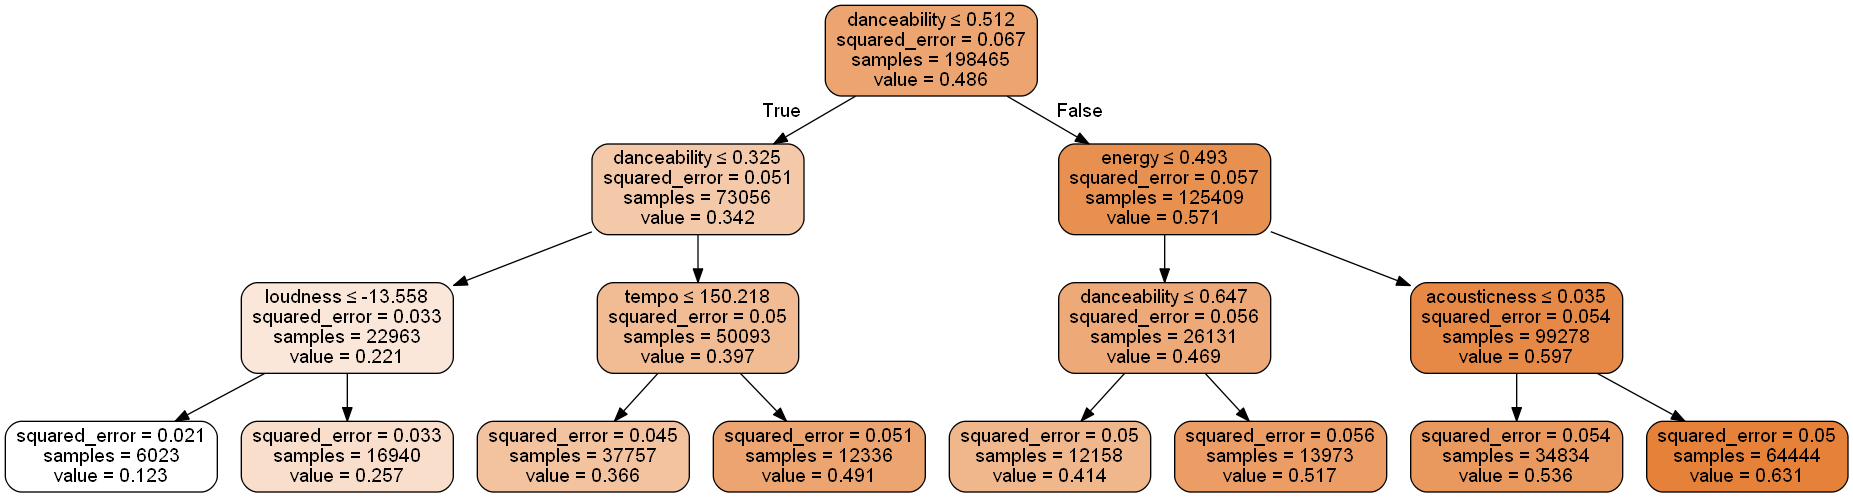

In [33]:
dot_data = StringIO()  
tree.export_graphviz(tree_train, out_file=dot_data,  
                     feature_names=X_train.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [34]:
X_test = test_dataset[test_dataset.columns[~test_dataset.columns.isin(['valence'])]]

train_not_test = X_train.columns.difference(X_test.columns)
print(train_not_test)

Index(['time_signature_1'], dtype='object')


In [35]:
X_test['time_signature_1'] = 0
X_test.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11', 'mode_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'time_signature_1'],
      dtype='object')

In [36]:
col = X_test.pop("time_signature_1")
X_test.insert(21, col.name, col)

y_pred_tree = tree_train.predict(X_test)
X_test.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11', 'mode_1', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

In [37]:
from sklearn.metrics import mean_absolute_error as MAE

mae44 = round(MAE(test_dataset['valence'], y_pred_tree),4)
mae44

0.1778

We did better than Linear Regression, without any tuning of the Hyper-parameters.

### XGBoost Regressor

In [38]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as MAE

Cross validate the hyperparameters.

We would ideally have a validation set, but we will use our test for that as well.

In [39]:
dtrain = xgb.DMatrix(X_train, label=train_set['valence'])
dvalid = xgb.DMatrix(X_test, label=test_dataset['valence'])
#dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#small: min_child_weight, eta
#large: subsample
xgb_pars = []
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'mae',
                                         'objective': 'reg:squarederror', 'seed' :42})
top_score = 1 
for _ in range(50):
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)
    if model.best_score < top_score:
        top_score = model.best_score
        top_pars = xgb_par

print(f"Top score is: {top_score}")
print(xgb_par)

{'min_child_weight': 20, 'eta': 0.15, 'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 0.7, 'lambda': 1.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'seed': 42}
[0]	train-mae:0.21820	valid-mae:0.19473
[100]	train-mae:0.13958	valid-mae:0.14788
[200]	train-mae:0.13398	valid-mae:0.14546
[300]	train-mae:0.13038	valid-mae:0.14446
[337]	train-mae:0.12934	valid-mae:0.14434
Modeling RMSLE 0.14427
{'min_child_weight': 10, 'eta': 0.1, 'colsample_bytree': 0.5, 'max_depth': 8, 'subsample': 0.5, 'lambda': 3.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'seed': 42}
[0]	train-mae:0.21884	valid-mae:0.19493
[100]	train-mae:0.13227	valid-mae:0.14630
[200]	train-mae:0.12432	valid-mae:0.14444
[300]	train-mae:0.11944	valid-mae:0.14312
[400]	train-mae:0.11528	valid-mae:0.14224
[500]	train-mae:0.11107	valid-mae:0.14156
[600]	train-mae:0.10718	valid-mae:0.14046
[700]	train-mae:0.10356	valid-mae:0.13969
[800]	

Using the best set of parameters, train a XCBoost model.

In [168]:
best_model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)

[0]	train-mae:0.21970	valid-mae:0.19537
[100]	train-mae:0.15232	valid-mae:0.16059
[200]	train-mae:0.13916	valid-mae:0.15267
[300]	train-mae:0.13234	valid-mae:0.14874
[400]	train-mae:0.12743	valid-mae:0.14606
[500]	train-mae:0.12409	valid-mae:0.14447
[600]	train-mae:0.12162	valid-mae:0.14358
[700]	train-mae:0.11925	valid-mae:0.14289
[800]	train-mae:0.11727	valid-mae:0.14218
[900]	train-mae:0.11585	valid-mae:0.14173
[1000]	train-mae:0.11439	valid-mae:0.14143
[1021]	train-mae:0.11409	valid-mae:0.14164


In [170]:
y_pred_xgboost = best_model.predict(dvalid)
round(MAE(y_pred_xgboost, test_dataset['valence']), 4)

0.1416

We notice that we did a lot better with XCBoost, our best so far.

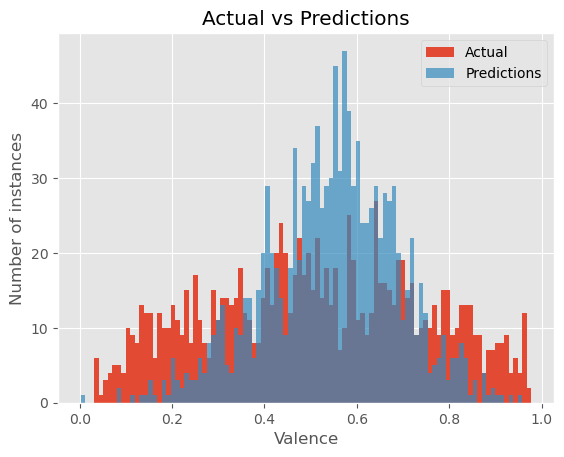

In [171]:
bins = np.histogram(np.hstack((test_dataset['valence'], y_pred_xgboost)), bins=100)[1] #get the bin edges
plt.hist(test_dataset['valence'], bins=bins, alpha=1)
plt.hist(y_pred_xgboost, bins=bins, alpha=0.7)
plt.title("Actual vs Predictions")
plt.xlabel("Valence")
plt.ylabel("Number of instances")
plt.legend(["Actual", "Predictions"])
plt.show()

Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Run cross validation to tune hyper parameters.

In [57]:
param_grid = {
    "n_estimators":[100, 200, 300, 500],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train, train_set['valence'])
rf_reg_tuned.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


RandomForestRegressor(max_depth=50, max_features=10, n_estimators=500)

Estimators (number in of trees in each iteration were costly, but slightly increased MAE)

In [58]:
final_rf_reg = RandomForestRegressor(criterion="mse",max_depth=50, max_features=10, n_estimators=500)
final_rf_reg.fit(X_train, train_set['valence'])

MAE(final_rf_reg.predict(X_test), test_dataset['valence'])

0.12564752114377695

In [59]:
MAE(rf_reg_tuned.predict(X_test), test_dataset['valence'])

0.12579750053550934

We notice that Random Forest is our best model to be used for predictions among our tries.